In [55]:
!pip install av -q
import av
import numpy as np

from transformers import AutoImageProcessor, TimesformerModel
from huggingface_hub import hf_hub_download


def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

file_path = "/content/video.mp4"
container = av.open(file_path)

# sample 8 frames
indices = sample_frame_indices(clip_len=8, frame_sample_rate=4, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
model = TimesformerModel.from_pretrained("facebook/timesformer-base-finetuned-k400")

# prepare video for the model
inputs = image_processor(list(video), return_tensors="pt")

# forward pass
outputs = model(**inputs ,output_attentions=True)
attentions = outputs.attentions
last_layer_attentions = attentions[-1]
print(last_layer_attentions.shape)

torch.Size([8, 12, 197, 197])


In [56]:
indices

array([ 1,  5, 10, 14, 19, 23, 28, 32])

In [57]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt


attn = last_layer_attentions.detach().cpu()  # shape: (B, H, 197, 197)
B, num_heads, seq_len, _ = attn.shape
heatmaps = []

for i in range(B):
    # Lấy attention của token CLS (index 0) đến các patch tokens (indices 1:197)
    # Kết quả có shape (num_heads, 196)
    attn_frame = attn[i, :, 0, 1:]

    # Tính trung bình attention qua các head, kết quả shape: (196,)
    attn_avg = attn_frame.mean(dim=0)

    # Chuẩn hóa attention (đưa về khoảng [0, 1])
    attn_norm = (attn_avg - attn_avg.min()) / (attn_avg.max() - attn_avg.min() + 1e-8)

    # Reshape thành lưới 14 x 14 (196 = 14*14)
    attn_grid = attn_norm.reshape(14, 14)

    # Chuyển sang tensor 4D (1, 1, 14, 14) để sử dụng hàm interpolate
    attn_grid = attn_grid.unsqueeze(0).unsqueeze(0)

    # Phóng to (interpolate) lên kích thước của ảnh gốc 224 x 224
    attn_up = F.interpolate(attn_grid, size=(224, 224), mode="bilinear", align_corners=False)
    attn_up = attn_up.squeeze().numpy()  # shape: (224, 224)

    heatmaps.append(attn_up)

overlay_images = []

for i in range(B):
    frame = video[i]  # shape: (H, W, 3)
    # Chuyển heatmap sang 8-bit [0, 255]
    heatmap = (heatmaps[i] * 255).astype(np.uint8)
    # Sử dụng OpenCV để áp dụng colormap (ví dụ: COLORMAP_JET)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Resize heatmap_color to match the size of the frame
    heatmap_color_resized = cv2.resize(heatmap_color, (frame.shape[1], frame.shape[0]))

    # Chuyển đổi frame từ RGB sang BGR (theo chuẩn của OpenCV)
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    # Blend (trộn) ảnh gốc với heatmap, thay đổi tham số alpha để điều chỉnh mức độ overlay
    overlay = cv2.addWeighted(frame_bgr, 0.6, heatmap_color_resized, 0.4, 0) # Use resized heatmap
    overlay_images.append(overlay)


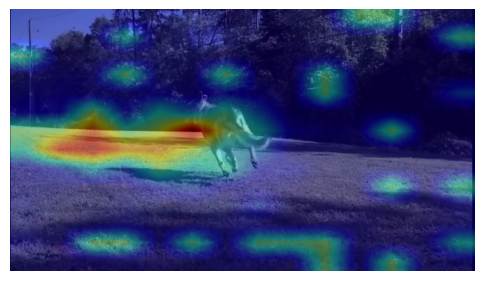

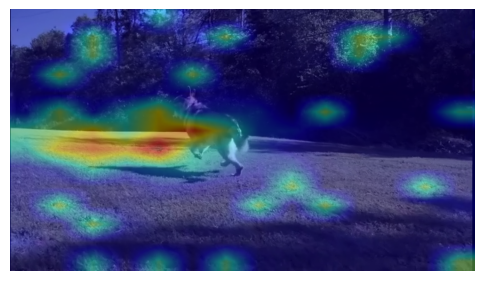

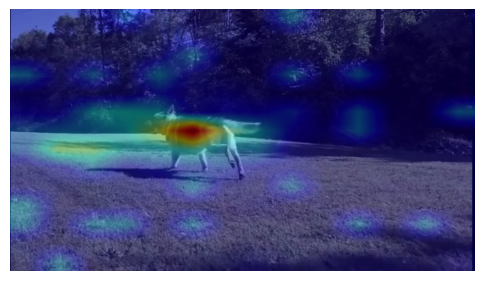

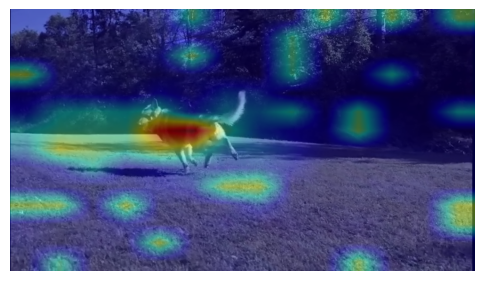

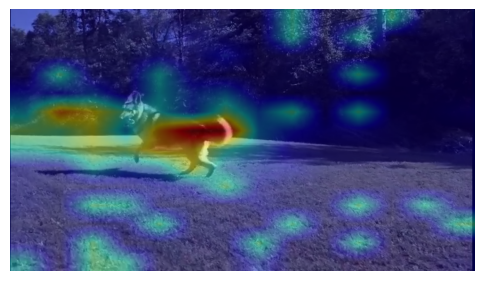

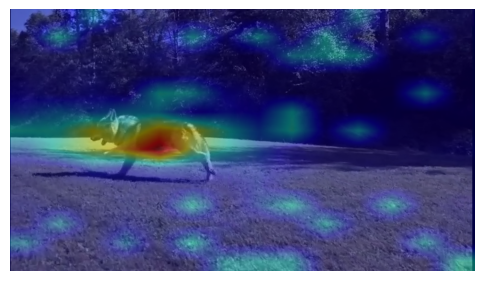

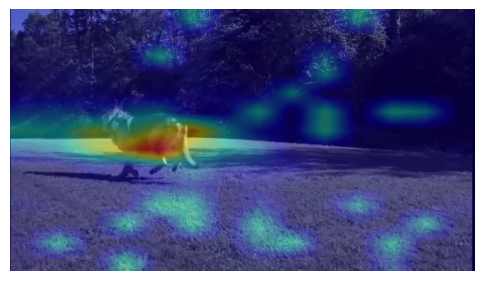

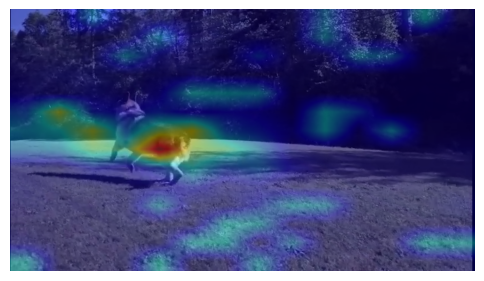

In [58]:
for i in range(B):
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(overlay_images[i], cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [59]:
from pathlib import Path
from einops import rearrange, repeat, reduce
import cv2
from google.colab.patches import cv2_imshow
import torch
import torchvision.transforms as transforms
from PIL import Image
import json
import matplotlib.pyplot as plt
import av
from torch import einsum

# export
DEFAULT_MEAN = [0.45, 0.45, 0.45]
DEFAULT_STD = [0.225, 0.225, 0.225]
# convert video path to input tensor for model
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(DEFAULT_MEAN,DEFAULT_STD),
    transforms.Resize(224),
    transforms.CenterCrop(224),
])

# convert the video path to input for cv2_imshow()
transform_plot = transforms.Compose([
    lambda p: cv2.imread(str(p),cv2.IMREAD_COLOR),
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    lambda x: rearrange(x*255, 'c h w -> h w c').numpy()
])


def get_frames(path_to_video, num_frames=8):
  "return a list of paths to the frames of sampled from the video"

  # Check if the input is a video file
  if path_to_video.is_file() and path_to_video.suffix in ['.mp4', '.avi', '.mov']:  # Add other supported formats if needed

    # Create a directory to store extracted frames
    frames_dir = path_to_video.parent / (path_to_video.stem + '_frames')
    frames_dir.mkdir(exist_ok=True)

    # Extract frames using PyAV
    with av.open(str(path_to_video)) as container:
      stream = container.streams.video[0]
      for i, frame in enumerate(container.decode(stream)):
        frame_path = frames_dir / f'{i:06d}.jpg'  # Save frames as JPG
        frame.to_image().save(frame_path)

    # Get list of extracted frames
    path_to_frames = list(frames_dir.iterdir())
    path_to_frames.sort(key=lambda f: int(f.with_suffix('').name[-6:]))

  else:
    # If not a video file, assume it's a directory of frames
    path_to_frames = list(path_to_video.iterdir())
    path_to_frames.sort(key=lambda f: int(f.with_suffix('').name[-6:]))

  assert num_frames <= len(path_to_frames), "num_frames can't exceed the number of frames extracted from videos"

  # Sample frames
  if len(path_to_frames) == num_frames:
    return path_to_frames
  else:
    video_length = len(path_to_frames)
    seg_size = float(video_length - 1) / num_frames
    seq = []
    for i in range(num_frames):
      start = int(np.round(seg_size * i))
      end = int(np.round(seg_size * (i + 1)))
      seq.append((start + end) // 2)
    path_to_frames_new = [path_to_frames[p] for p in seq]
    return path_to_frames_new

def create_video_input(path_to_video):
  "create the input tensor for TimeSformer model"
  path_to_frames = get_frames(path_to_video)
  frames = [transform(cv2.imread(str(p), cv2.IMREAD_COLOR)) for p in path_to_frames]
  frames = torch.stack(frames, dim=0)
  #frames = rearrange(frames, 't c h w -> c t h w')
  frames = frames.unsqueeze(dim=0)
  return(frames)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def create_masks(masks_in, np_imgs):
  masks = []
  for mask, img in zip(masks_in, np_imgs):
    mask= cv2.resize(mask, (img.shape[1], img.shape[0]))
    mask = show_mask_on_image(img, mask)
    masks.append(mask)
  return(masks)

In [60]:
# export
def combine_divided_attention(attn_t, attn_s):
  ## time attention
    # average time attention weights across heads
  attn_t = attn_t.mean(dim = 1)
    # add cls_token to attn_t as an identity matrix since it only attends to itself
  I = torch.eye(attn_t.size(-1)).unsqueeze(0)
  attn_t = torch.cat([I,attn_t], 0)
    # adding identity matrix to account for skipped connection
  attn_t = attn_t +  torch.eye(attn_t.size(-1))[None,...]
    # renormalize
  attn_t = attn_t / attn_t.sum(-1)[...,None]

  ## space attention
   # average across heads
  attn_s = attn_s.mean(dim = 1)
   # adding residual and renormalize
  attn_s = attn_s +  torch.eye(attn_s.size(-1))[None,...]
  attn_s = attn_s / attn_s.sum(-1)[...,None]

  ## combine the space and time attention
  attn_ts = einsum('tpk, ktq -> ptkq', attn_s, attn_t)

  ## average the cls_token attention across the frames
   # splice out the attention for cls_token
  attn_cls = attn_ts[0,:,:,:]
   # average the cls_token attention and repeat across the frames
  attn_cls_a = attn_cls.mean(dim=0)
  attn_cls_a = repeat(attn_cls_a, 'p t -> j p t', j = 8)
   # add it back
  attn_ts = torch.cat([attn_cls_a.unsqueeze(0),attn_ts[1:,:,:,:]],0)
  return(attn_ts)

class DividedAttentionRollout():
  def __init__(self, model, **kwargs):
    self.model = model
    self.hooks = []

  def get_attn_t(self, module, input, output):
    self.time_attentions.append(output.detach().cpu())
  def get_attn_s(self, module, input, output):
    self.space_attentions.append(output.detach().cpu())

  def remove_hooks(self):
    for h in self.hooks: h.remove()

  def __call__(self):
    input_tensor = inputs['pixel_values']
    self.model.zero_grad()
    self.time_attentions = []
    self.space_attentions = []
    self.attentions = []
    for name, m in model.named_modules():
      if 'temporal_attention.attention.attn_drop' in name:
        self.hooks.append(m.register_forward_hook(self.get_attn_t))
      elif 'attention.attention.attn_drop' in name:
        self.hooks.append(m.register_forward_hook(self.get_attn_s))
    preds = self.model(input_tensor)
    for h in self.hooks: h.remove()
    for attn_t,attn_s in zip(self.time_attentions, self.space_attentions):
      self.attentions.append(combine_divided_attention(attn_t,attn_s))
    p,t = self.attentions[0].shape[0], self.attentions[0].shape[1]
    result = torch.eye(p*t)
    for attention in self.attentions:
      attention = rearrange(attention, 'p1 t1 p2 t2 -> (p1 t1) (p2 t2)')
      result = torch.matmul(attention, result)
    mask = rearrange(result, '(p1 t1) (p2 t2) -> p1 t1 p2 t2', p1 = p, p2=p)
    mask = mask.mean(dim=1)
    mask = mask[0,1:,:]
    width = int(mask.size(0)**0.5)
    mask = rearrange(mask, '(h w) t -> h w t', w = width).numpy()
    mask = mask / np.max(mask)
    return(mask, self.time_attentions, self.space_attentions)



In [61]:
att_roll = DividedAttentionRollout(model)
masks, time_attention, space_attention = att_roll()

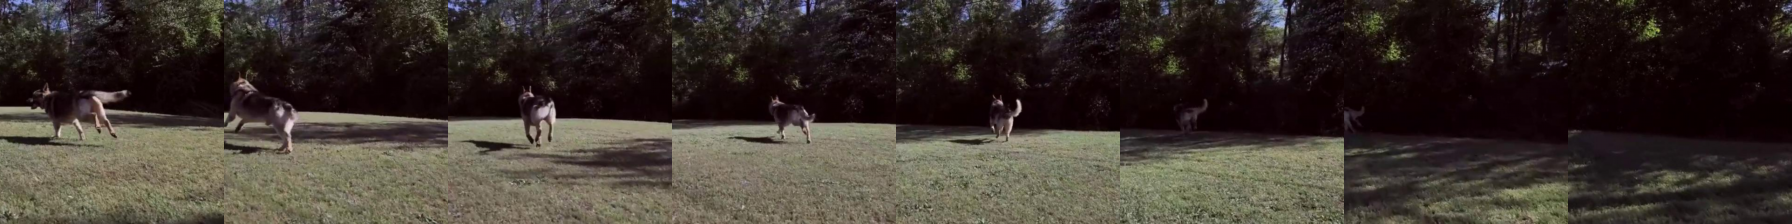

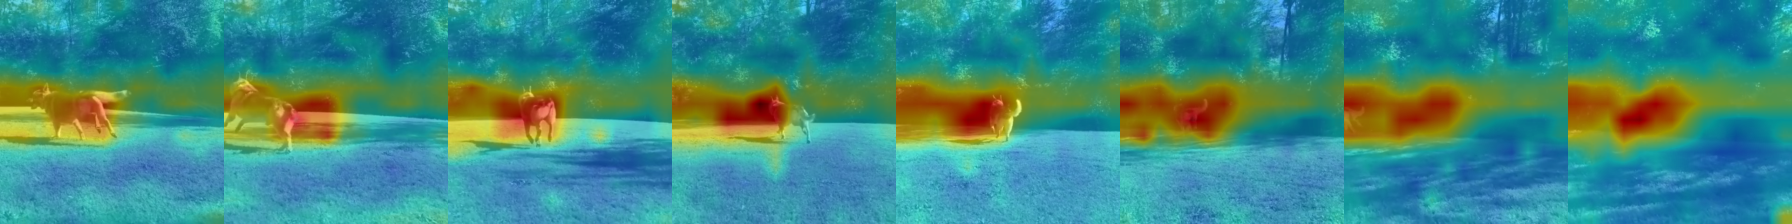

In [62]:
path_to_video = Path('/content/video.mp4')
path_to_video.exists()
np_imgs = [transform_plot(p) for p in get_frames(path_to_video)]
masks = create_masks(list(rearrange(masks, 'h w t -> t h w')),np_imgs)
cv2_imshow(np.hstack(np_imgs))
cv2_imshow(np.hstack(masks))

In [63]:
space_attn = space_attention[-1]
time_attn = time_attention[-1]

In [64]:
space_attn.shape

torch.Size([8, 12, 197, 197])

Các patch được chọn từ frame 0 (theo CLS attention): tensor([ 89, 100,  99])
Các cặp (i, j) được chọn: [(tensor(89), 46), (tensor(100), 8), (tensor(99), 46)]


<ipython-input-65-b9adfca79cb5>:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


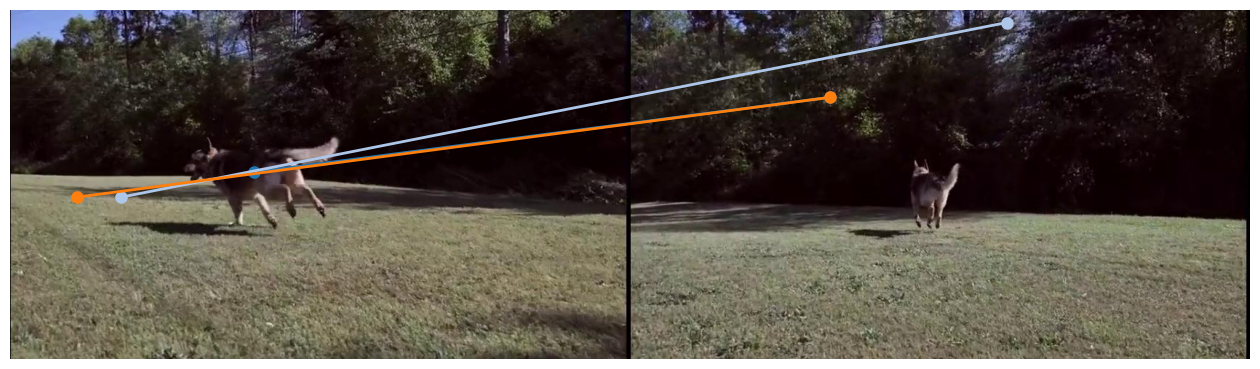

In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.cm as cm

time_attn_np = time_attn.cpu().detach().numpy()    # shape: (196, 12, 8, 8)
space_attn_np = space_attn.cpu().detach().numpy()    # shape: (8, 12, 192, 192)

# ---------------------------
# Bước A: Tính effective attention giữa frame 0 và frame 2
num_patches = 196
num_heads = time_attn_np.shape[1]  # 12
effective_attn = np.zeros((num_patches, num_patches))  # (196,196)
for i in range(num_patches):
    for h in range(num_heads):
        # Lấy trọng số time attention cho patch i, head h: query time = 0, key time = 2
        t_weight = time_attn_np[i, h, 0, 2]
        # Trong space attention của frame 2, với head h, bỏ qua token [CLS]:
        # giả sử patch i ở frame 0 tương ứng với token (i+1) trong space attention của frame 2
        s_weights = space_attn_np[2, h, i+1, 1:]  # shape: (196,)
        effective_attn[i] += t_weight * s_weights
effective_attn /= num_heads  # trung bình qua các head

# # ---------------------------
#     attn_frame = attn[i, :, 0, 1:]

#     # Tính trung bình attention qua các head, kết quả shape: (196,)
#     attn_avg = attn_frame.mean(dim=0)

#     # Chuẩn hóa attention (đưa về khoảng [0, 1])
#     attn_norm = (attn_avg - attn_avg.min()) / (attn_avg.max() - attn_avg.min() + 1e-8)

#     # Reshape thành lưới 14 x 14 (196 = 14*14)
#     attn_grid = attn_norm.reshape(14, 14)
# Bước B: Từ space_attention của frame 0, chọn các patch i có trọng số cao nhất
average_space0 = space_attn[0, :, 0, 1:]
attn0_no_cls = average_space0.mean(dim=0)  # shape: (196,)
#aggregated = attn0_no_cls.sum(dim=1)  # shape: [196]
top_k = 3
top_values, selected_indices  = torch.topk(attn0_no_cls, top_k)
print("Các patch được chọn từ frame 0 (theo CLS attention):", selected_indices)

# ---------------------------
# Bước C: Với mỗi patch i được chọn, tìm patch j trên frame 2 sao cho effective_attn[i, j] cao nhất
selected_pairs = []
for i in selected_indices:
    j = np.argmax(effective_attn[i])
    selected_pairs.append((i, j))
print("Các cặp (i, j) được chọn:", selected_pairs)

# ---------------------------
# Bước D: Đọc ảnh frame 0 và frame 2 từ đĩa
frame0 = np.array(Image.open('/content/video_frames/000012.jpg'))
frame2 = np.array(Image.open('/content/video_frames/000098.jpg'))


H, W, _ = frame2.shape
combined_img = np.concatenate((frame0, frame2), axis=1)  # shape: (H, 2*W, 3)
grid_rows, grid_cols = 14, 14
patch_h = H / grid_rows
patch_w = W / grid_cols

def patch_center(idx, offset_x=0):
    """
    Tính tọa độ tâm của patch với chỉ số idx (0 đến 195) theo lưới 14x14.
    Nếu offset_x != 0, dịch tọa độ x sang bên phải (cho frame 2).
    """
    i = idx // grid_cols  # hàng
    j = idx % grid_cols   # cột
    center_y = (i + 0.5) * patch_h
    center_x = (j + 0.5) * patch_w + offset_x
    return center_x, center_y


plt.figure(figsize=(16, 8))
plt.imshow(combined_img)
plt.axis('off')
cmap = cm.get_cmap('tab20')

for idx, (i, j) in enumerate(selected_pairs):
    x0, y0 = patch_center(i, offset_x=0)
    x2, y2 = patch_center(j, offset_x=W)
    color = cmap(idx % 20)
    plt.plot([x0, x2], [y0, y2], color=color, linewidth=2, marker='o', markersize=8)
plt.show()
